In [40]:
import numpy as np 
import pandas as pd 
import os
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torchvision
import os
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.manifold import TSNE

In [4]:
#setting the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load csv

In [5]:
df_image = pd.read_csv('/kaggle/input/utkface-convert-csv/utkface_sortAge.csv')
df_image

,Unnamed: 0,age,gender,ethnicity,image
0,2226,1,1,0,109 146 198 132 169 221 134 171 223 137 174 22...
1,2047,1,0,3,0 1 2 2 1 1 5 1 0 11 3 3 1 0 6 27 35 45 97 111...
2,2048,1,0,3,54 64 91 55 66 95 56 72 105 58 76 113 67 85 12...
3,2049,1,0,3,80 98 125 77 94 129 113 131 169 147 169 201 16...
4,2050,1,0,3,63 55 96 58 51 94 72 67 112 83 80 126 91 90 13...
...,...,...,...,...,...
23703,183,115,1,1,175 211 219 177 210 219 176 206 215 166 195 20...
23704,184,116,1,0,12 76 199 41 60 149 60 87 123 96 118 167 119 1...
23705,185,116,1,0,61 77 93 70 88 104 77 97 115 81 102 123 85 109...
23706,186,116,1,2,193 208 210 183 201 206 177 197 207 160 184 19...


In [6]:
df_image = df_image[df_image['ethnicity'].map(len) == 1]
df_image.reset_index(drop=True, inplace=True)

# Prepare custom dataset and make dataloader

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.array([int(pixel) for pixel in self.data.iloc[idx]['image'].split()])
        image = image.reshape(50, 50, 3).astype(np.uint8)
        age = self.data.iloc[idx]['age']  # Age as target label
        gender = self.data.iloc[idx]['gender']  # Gender as target label
        ethnicity = int(self.data.iloc[idx]['ethnicity'])  # Ethnicity as target label
        if self.transform:
            image = self.transform(image)
        return image, {'age': age, 'gender': gender, 'ethnicity': ethnicity}

# Split the dataset into train, test, and validation sets
train_data, test_data = train_test_split(df_image, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Create DataLoader instances for each dataset split
transform = transforms.Compose([
    transforms.ToTensor(), 
])

batch_size = 64
train_dataset = CustomDataset(train_data, transform=transform)
val_dataset = CustomDataset(val_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize the dataset 

267
267


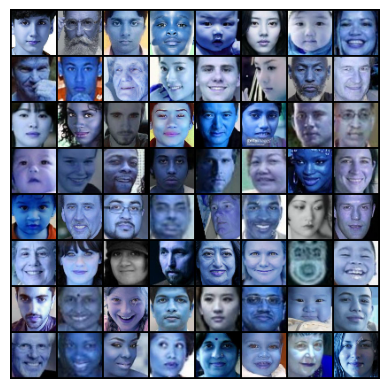

Age: tensor([16, 60, 28,  9,  1, 28,  2, 41, 62, 26, 99, 24, 20, 28, 58, 65, 24, 33,
        26, 21, 36, 16, 35, 57,  2, 18, 27, 16, 26, 76, 26, 29,  2, 50, 34, 55,
        41, 26, 24, 35, 55, 29, 28, 53, 65, 46, 54, 10, 24, 61,  9, 22, 26, 30,
         1, 24, 60, 28, 31, 35, 36,  2, 70, 18])
Gender: tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1])
Ethnicity: tensor([0, 0, 3, 1, 2, 2, 2, 1, 0, 1, 0, 2, 0, 2, 1, 0, 2, 1, 0, 2, 2, 3, 0, 3,
        2, 0, 1, 1, 4, 2, 1, 0, 3, 0, 4, 3, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 4,
        4, 3, 0, 3, 2, 3, 2, 4, 0, 1, 1, 1, 3, 4, 0, 0])


In [8]:
# Function to unnormalize and plot a single image
def imshow(img):
#     img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

print(len(train_loader))
# Get some random training images
dataiter = iter(train_loader)

print(len(dataiter))
images, labels = next(dataiter)

# Plot images along with their labels
imshow(torchvision.utils.make_grid(images))
print('Age:', labels['age'])
print('Gender:', labels['gender'])
print('Ethnicity:', labels['ethnicity'])

# Autoencoder

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder_linear1 = nn.Linear(50*50*3, 512)
        self.encoder_linear2 = nn.Linear(512, latent_dims)

        # Decoder layers
        self.decoder_linear1 = nn.Linear(latent_dims, 512)
        self.decoder_linear2 = nn.Linear(512, 50*50*3)

    def encode(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.encoder_linear1(x))
        z = self.encoder_linear2(x)
        return z

    def decode(self, z):
        z = F.relu(self.decoder_linear1(z))
        reconstructed_x = torch.sigmoid(self.decoder_linear2(z))
        return reconstructed_x.reshape((-1, 3, 50, 50))

    def forward(self, x):
        z = self.encode(x)
        reconstructed_x = self.decode(z)
        return reconstructed_x

# Variational Autoencoder

In [10]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()

        # Encoder layers
        self.encoder_linear1 = nn.Linear(50*50*3, 512)
        self.encoder_linear2 = nn.Linear(512, latent_dims)
        self.encoder_linear3 = nn.Linear(512, latent_dims)

        # Decoder layers
        self.decoder_linear1 = nn.Linear(latent_dims, 512)
        self.decoder_linear2 = nn.Linear(512, 50*50*3)

        # Normal distribution for sampling
        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda()  # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()

        # KL divergence placeholder
        self.kl = 0

    def encode(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.encoder_linear1(x))
        mu = self.encoder_linear2(x)
        sigma = torch.exp(self.encoder_linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

    def decode(self, z):
        z = F.relu(self.decoder_linear1(z))
        reconstructed_x = torch.sigmoid(self.decoder_linear2(z))
        return reconstructed_x.view(-1, 3, 50, 50)  # Reshape to 3-channel image

    def forward(self, x):
        z = self.encode(x)
        reconstructed_x = self.decode(z)
        return reconstructed_x



# Training Function

In [11]:
def train(autoencoder, train_loader, val_loader, epochs=3, type="AE"):
    train_losses = []
    val_losses = []

    if type == "AE":
        opt = torch.optim.Adam(autoencoder.parameters())
        for epoch in range(1, epochs + 1):
            train_loss = 0.0
            val_loss = 0.0
            for x, _ in train_loader:
                x = x.to(device)  # Move data to GPU if available
                opt.zero_grad()
                x_hat = autoencoder(x)
                loss = ((x - x_hat)**2).sum()
                loss.backward()
                opt.step()
                train_loss += loss.item()
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            with torch.no_grad():
                for x, _ in val_loader:
                    x = x.to(device)
                    x_hat = autoencoder(x)
                    loss = ((x - x_hat)**2).sum()
                    val_loss += loss.item()
                val_loss /= len(val_loader.dataset)
                val_losses.append(val_loss)

            print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    elif type == "VAE":
        opt = torch.optim.Adam(autoencoder.parameters())
        for epoch in range(1, epochs + 1):
            train_loss = 0.0
            val_loss = 0.0
            for x, _ in train_loader:
                x = x.to(device)
                opt.zero_grad()
                x_hat = autoencoder(x)
                reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
                loss = reconstruction_loss + autoencoder.kl
                loss.backward()
                opt.step()
                train_loss += loss.item()
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            with torch.no_grad():
                for x, _ in val_loader:
                    x = x.to(device)
                    x_hat = autoencoder(x)
                    reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
                    loss = reconstruction_loss + autoencoder.kl
                    val_loss += loss.item()
                val_loss /= len(val_loader.dataset)
                val_losses.append(val_loss)

            print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    return autoencoder

# Plot Latent

In [12]:
def plot_latent(autoencoder, data, num_batches=100):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create subplots

    for i, (x, y) in enumerate(data):
        x = x.to(device)  # Move data to GPU if available
        z = autoencoder.encode(x)
        z = z.to('cpu').detach().numpy()

        # Plot for age
        axs[0].scatter(z[:, 0], z[:, 1], c=y['age'], cmap='tab10')
        axs[0].set_title('Age')
        axs[0].set_xlabel('Latent Dimension 1')
        axs[0].set_ylabel('Latent Dimension 2')

        # Plot for gender
        axs[1].scatter(z[:, 0], z[:, 1], c=y['gender'], cmap='tab10')
        axs[1].set_title('Gender')
        axs[1].set_xlabel('Latent Dimension 1')
        axs[1].set_ylabel('Latent Dimension 2')

        # Plot for ethnicity
        axs[2].scatter(z[:, 0], z[:, 1], c=y['ethnicity'], cmap='tab10')
        axs[2].set_title('Ethnicity')
        axs[2].set_xlabel('Latent Dimension 1')
        axs[2].set_ylabel('Latent Dimension 2')

        if i >= num_batches:
            break

    plt.tight_layout()
    plt.show()

# Plot Reconstruction

In [13]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 50
    h = 50
    img = np.zeros((n*h, n*w, 3))  # For color images, specify 3 channels
    device = next(autoencoder.parameters()).device
    
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y] for _ in range(100)]).to(device)
            x_hat = autoencoder.decode(z)
#             print(x_hat.shape)
            x_hat = x_hat.view(-1, 3, 50, 50).cpu().detach().numpy().transpose(0, 2, 3, 1)
            img[(n-1-i)*h:(n-1-i+1)*h, j*w:(j+1)*w, :] = x_hat.mean(axis=0)
    
    plt.imshow(img, extent=[*r0, *r1])
    plt.title('Reconstructed Images')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

# Plot tSne

In [41]:
def tsne(autoencoder, data, num_batches=100):
    latent_points = []
    labels = []  # Initialize labels list
    for i, (x, y) in enumerate(data):
        x = x.to(device)  # Move data to GPU if available
        z = autoencoder.encode(x)
        z = z.to('cpu').detach().numpy()
        latent_points.append(z)
        labels.append(y['age'].numpy())  # Append labels

        if i >= num_batches:
            break

    latent_points = np.concatenate(latent_points, axis=0)
    labels = np.concatenate(labels, axis=0)  # Concatenate labels properly

    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_points = tsne.fit_transform(latent_points)

    # Plot t-SNE points
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_points[:, 0], tsne_points[:, 1], c=labels, cmap='tab10')
    plt.colorbar(label='Age')
    plt.title('t-SNE Visualization of Latent Space')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


# Plot Interplotation

In [78]:
def interpolate(autoencoder, x_1, x_2, n=12):
    # Ensure input tensors have the correct shape
    x_1 = x_1.unsqueeze(0) if len(x_1.shape) == 3 else x_1
    x_2 = x_2.unsqueeze(0) if len(x_2.shape) == 3 else x_2

    z_1 = autoencoder.encode(x_1)
    z_2 = autoencoder.encode(x_2)
    z = torch.stack([z_1 + (z_2 - z_1) * t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decode(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 50
    h = 50
    img = np.zeros((w, n * w, 3))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i * w:(i + 1) * w] = x_hat.reshape(3, 50, 50).transpose(1, 2, 0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

# Elbo

In [131]:
def calculate_elbo(vae, data_loader):
    vae.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            recon_batch, mu, logvar = vae(data)
            # Reconstruction loss
            reconstruction_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
            # KL divergence
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            total_loss += reconstruction_loss + kl_divergence
    return total_loss / len(data_loader.dataset)

# Initializing the model

Epoch [1/3], Train Loss: 299.5245, Validation Loss: 254.5375
Epoch [2/3], Train Loss: 249.3499, Validation Loss: 253.3925
Epoch [3/3], Train Loss: 238.7668, Validation Loss: 239.2567


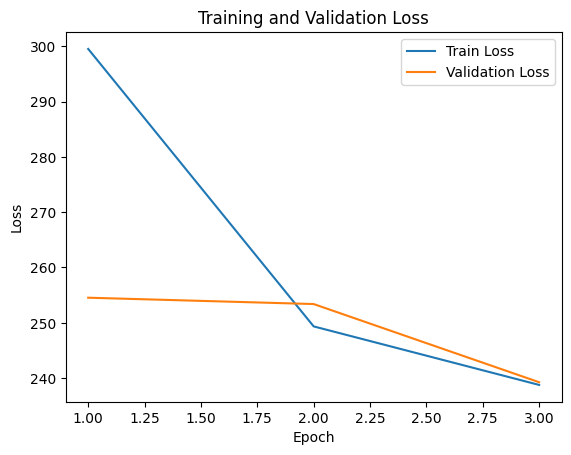

In [14]:
latent_dims = 2
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, train_loader,val_loader, type="VAE")

Epoch [1/3], Train Loss: 256.7027, Validation Loss: 231.7088
Epoch [2/3], Train Loss: 223.9518, Validation Loss: 226.7009
Epoch [3/3], Train Loss: 219.2415, Validation Loss: 221.9513


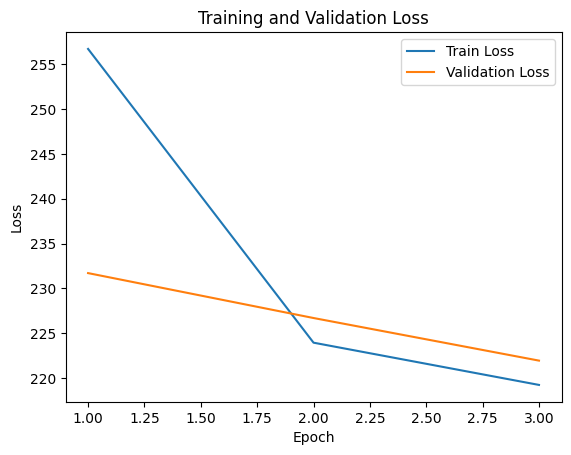

In [15]:
ae = Autoencoder(latent_dims).to(device)
ae = train(ae,train_loader,val_loader, type='AE')

# Plot the latent vectors

### Variational autoencoders

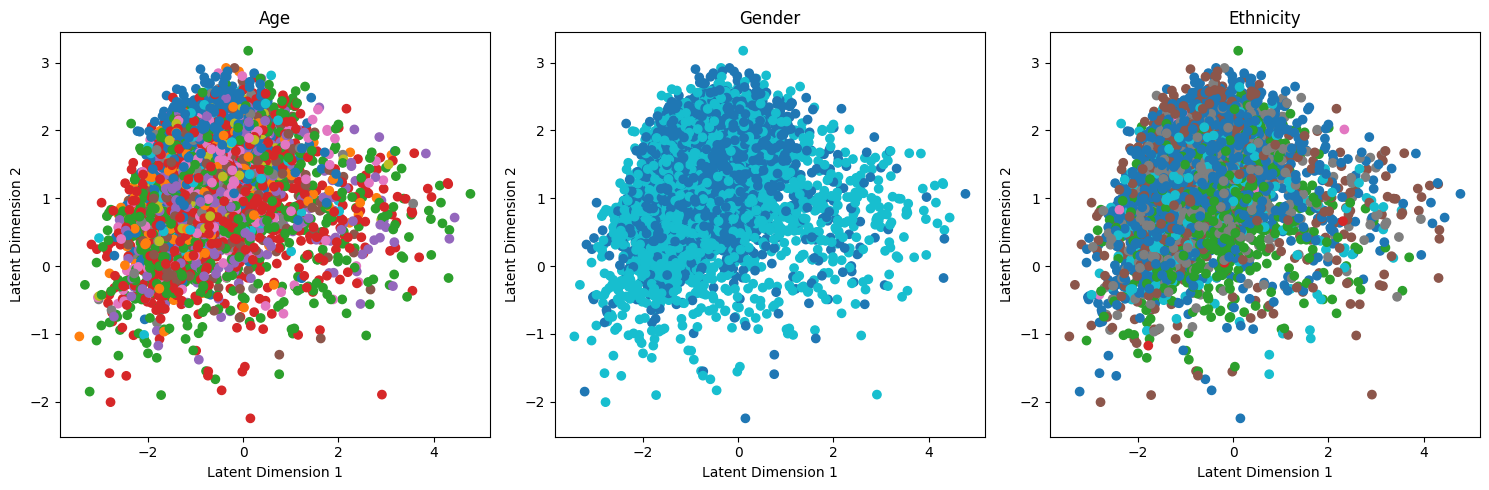

In [16]:
plot_latent(vae, train_loader)

### Autoencoders

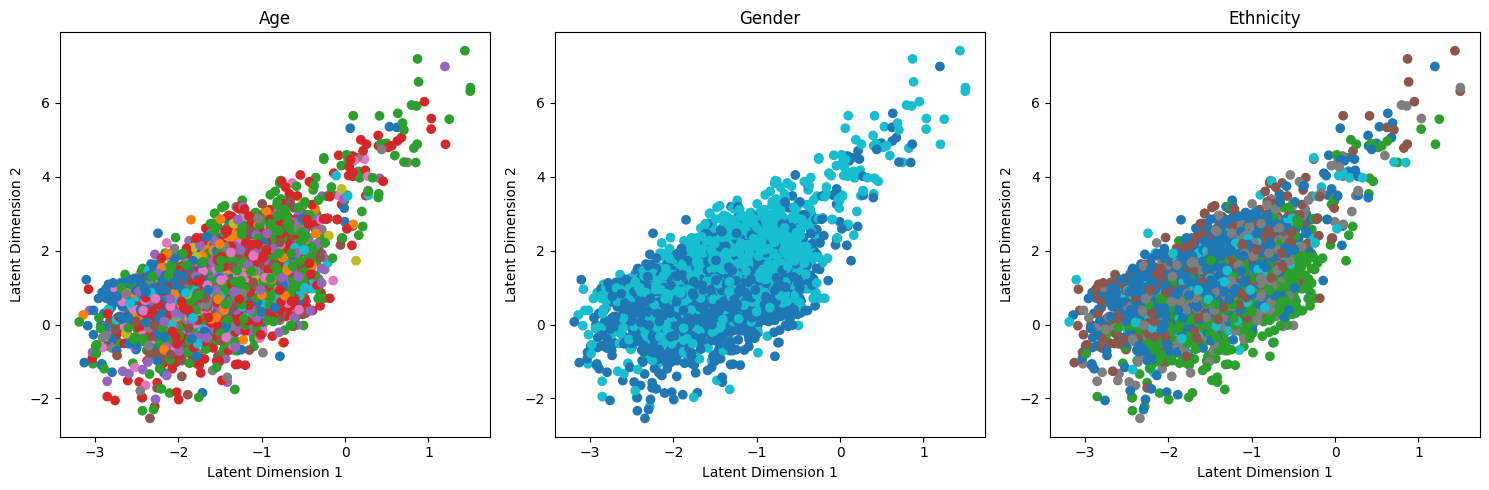

In [17]:
plot_latent(ae, train_loader)

# Reconstruct the images

### Variational Autoencoder

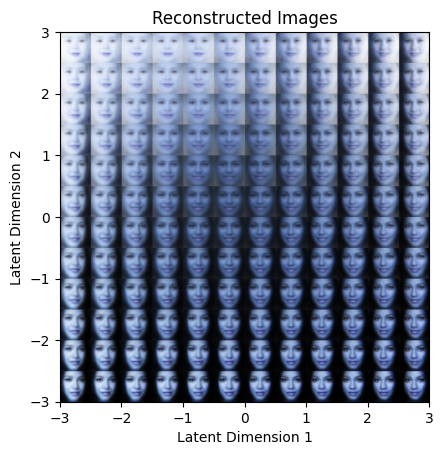

In [18]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

### Autoencoder

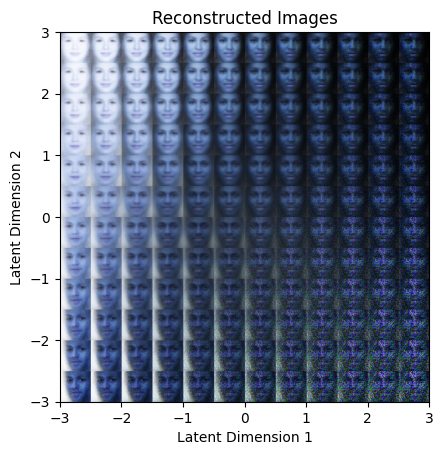

In [19]:
plot_reconstructed(ae, r0=(-3, 3), r1=(-3, 3))

# t-Sne Plot

### Variational Autoencoder

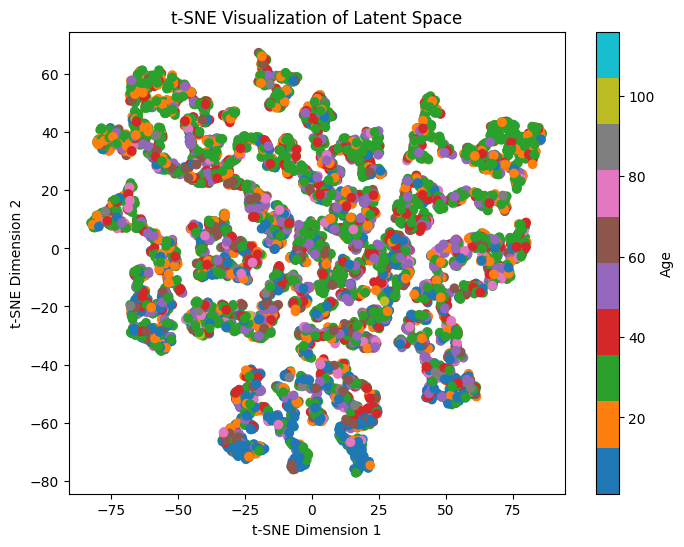

In [42]:
tsne(vae, train_loader)

### Autoencoder

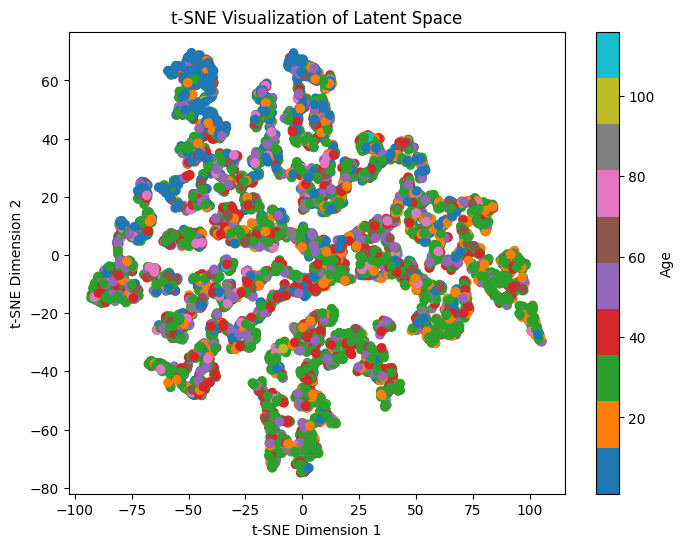

In [43]:
tsne(ae, train_loader)

# Interplolation

### Variational Autoencoder

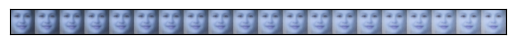

In [79]:
test_it = iter(test_loader)
x,y = next(test_it)

x_1 = x[y['gender'] == 1][1].to(device) # find a 1
x_2 = x[y['gender'] == 0][1].to(device) # find a 0
# print(x_1)
# print(x_2)
interpolate(vae, x_1, x_2, n=20)

### Autoencoder

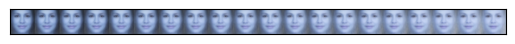

In [80]:
interpolate(ae, x_1, x_2, n=20)

# Introducing Convolutional Blocks and Dense Blocks

In [60]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvolutionalBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.batch_norm1(self.conv1(x)))
        out = F.relu(self.batch_norm2(self.conv2(out)))
        out = F.max_pool2d(out, kernel_size=2, stride=2)
        return out

class DenseBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(DenseBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        return out

class VariationalAutoencoderCNN(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoderCNN, self).__init__()

        # Encoder layers
        self.conv_block = ConvolutionalBlock(3, 32)
        self.dense_block = DenseBlock(32 * 25 * 25, 512)  # Adjust the input size accordingly
        self.encoder_linear1 = nn.Linear(512, latent_dims)
        self.encoder_linear2 = nn.Linear(512, latent_dims)

        # Decoder layers
        self.decoder_linear1 = nn.Linear(latent_dims, 512)
        self.decoder_linear2 = nn.Linear(512, 32 * 25 * 25)  # Adjust the output size accordingly
        self.conv_transpose = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Normal distribution for sampling
        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda()
            self.N.scale = self.N.scale.cuda()

        # KL divergence placeholder
        self.kl = 0

    def encode(self, x):
        out = self.conv_block(x)
        out = torch.flatten(out, start_dim=1)
        out = self.dense_block(out)
        mu = self.encoder_linear1(out)
        sigma = torch.exp(self.encoder_linear2(out))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

    def decode(self, z):
        out = F.relu(self.decoder_linear1(z))
        out = F.relu(self.decoder_linear2(out))
        out = out.view(-1, 32, 25, 25)  # Reshape to match the output of conv_block
        reconstructed_x = torch.sigmoid(self.conv_transpose(out))
        return reconstructed_x

    def forward(self, x):
        z = self.encode(x)
        reconstructed_x = self.decode(z)
        return reconstructed_x


In [66]:
def compute_loss(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    total_kl = 0.0
    with torch.no_grad():
        for batch in data_loader:
            images, _ = batch
            images = images.to(device)

            recon_images = model(images)
            recon_loss = F.binary_cross_entropy(recon_images, images, reduction='sum')

            kl_loss = model.kl

            total_loss += recon_loss.item() + kl_loss.item()
            total_kl += kl_loss.item()

    avg_loss = total_loss / len(data_loader.dataset)
    avg_kl = total_kl / len(data_loader.dataset)
    return avg_loss, avg_kl

def train(model, train_loader, val_loader, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        optimizer = torch.optim.Adam(model.parameters())
        running_loss = 0.0
        for batch in train_loader:
            images, _ = batch
            images = images.to(device)

            optimizer.zero_grad()

            recon_images = model(images)
            recon_loss = F.binary_cross_entropy(recon_images, images, reduction='sum')

            kl_loss = model.kl
            loss = recon_loss + kl_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader.dataset)
        val_loss, val_kl = compute_loss(model, val_loader, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val KL: {val_kl:.4f}")
        
    return model


In [67]:
latent_dims = 2
vae_cnn = VariationalAutoencoderCNN(latent_dims).to(device) # GPU
vae_cnn = train(vae_cnn, train_loader,val_loader)

Epoch 1/3, Train Loss: 4790.3371, Val Loss: 4664.1176, Val KL: 7.8158
Epoch 2/3, Train Loss: 4653.0833, Val Loss: 4620.0907, Val KL: 8.5631
Epoch 3/3, Train Loss: 4623.7811, Val Loss: 4622.8881, Val KL: 8.0867


## Plot Latent

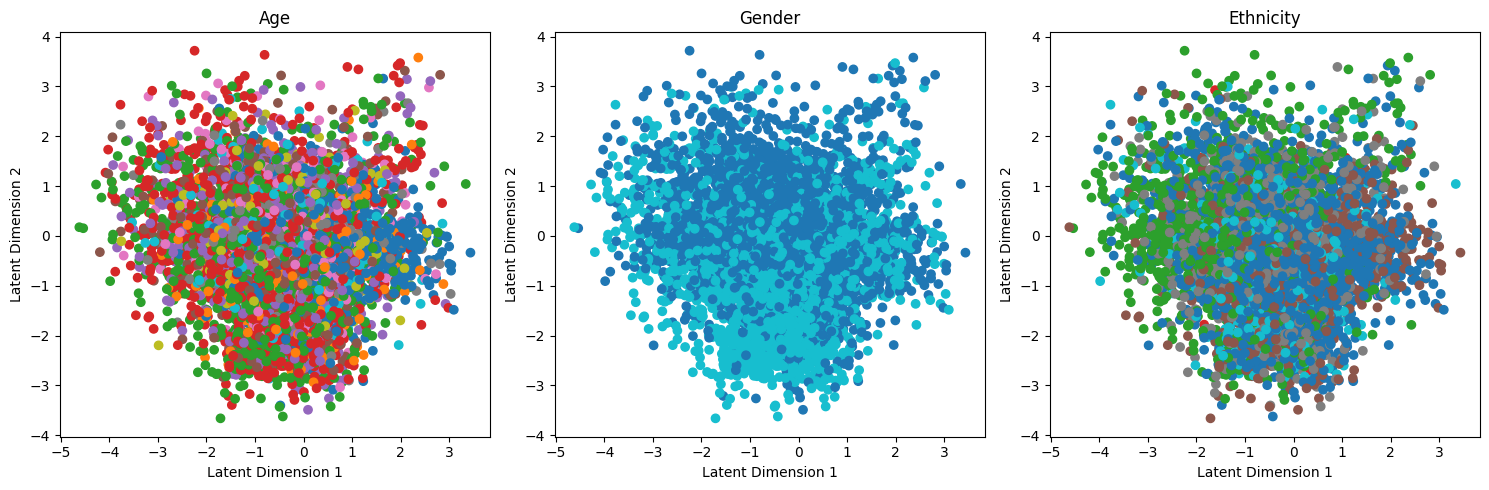

In [68]:
plot_latent(vae_cnn, train_loader)

## Plot Reconstructed Image

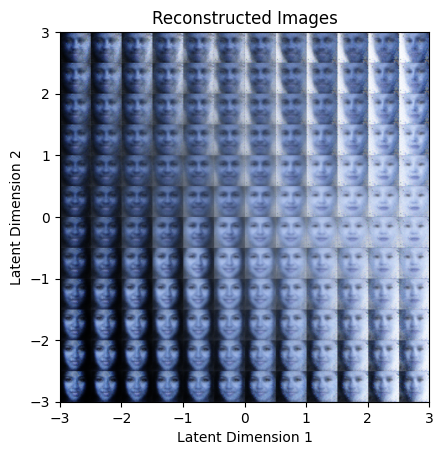

In [69]:
plot_reconstructed(vae_cnn, r0=(-3, 3), r1=(-3, 3))

## Plot Tsne

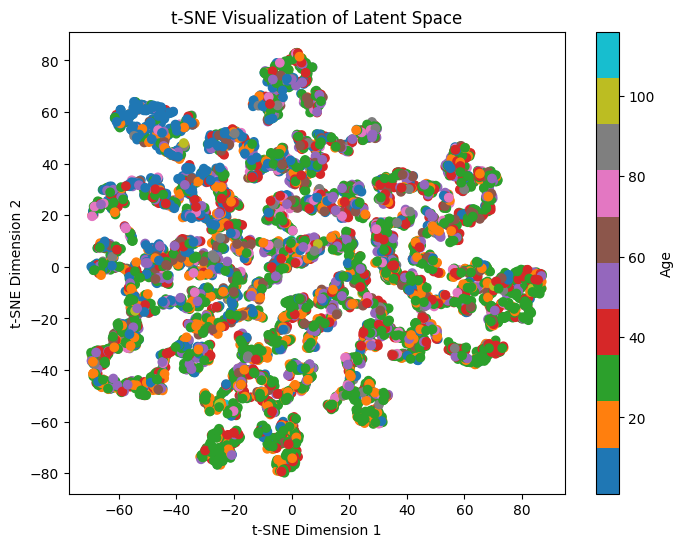

In [70]:
tsne(vae_cnn, train_loader)

# Classification using Latent Representation

In [107]:
for data, labels in train_loader:
    print(labels)
    break

{'age': tensor([ 4, 39, 14, 22, 35, 65, 45, 25, 63, 23, 49, 25,  1, 36, 30, 35, 14, 35,
        35, 80, 38, 58, 35, 59, 40, 54, 21, 38, 24, 20, 62, 56,  1, 58, 36, 26,
        35, 24, 15, 27, 30, 35, 72, 32, 30,  5, 27, 26, 28, 28, 16, 25, 26, 37,
        35, 44, 22, 22, 27, 40, 26, 15, 49, 31]), 'gender': tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]), 'ethnicity': tensor([3, 0, 0, 1, 2, 4, 1, 1, 0, 3, 0, 3, 3, 0, 2, 2, 0, 3, 4, 2, 1, 4, 2, 0,
        0, 0, 3, 2, 1, 0, 0, 3, 0, 0, 0, 3, 2, 3, 0, 2, 3, 0, 0, 0, 1, 2, 2, 2,
        2, 2, 0, 2, 1, 0, 1, 0, 2, 1, 0, 1, 3, 3, 0, 1])}


In [82]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [111]:
def extract_latent(model, data_loader):
    model.eval()
    latent_list = []
    label_list = []
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.cuda() if torch.cuda.is_available() else data
            z = model.encode(data)
            latent_list.append(z.cpu().numpy())
            label_list.append(labels['gender'].numpy())
    latent_array = np.concatenate(latent_list, axis=0)
    label_array = np.concatenate(label_list, axis=0)
    return latent_array, label_array

In [119]:
train_latent, train_labels = extract_latent(vae, train_loader)
print("Train Latent Shape:", train_latent.shape)
print("Train Labels Shape:", train_labels.shape)

val_latent, val_labels = extract_latent(vae, val_loader)
print("Train Latent Shape:", val_latent.shape)
print("Train Labels Shape:", val_labels.shape)

Train Latent Shape: (17067, 2)
Train Labels Shape: (17067,)
Train Latent Shape: (1897, 2)
Train Labels Shape: (1897,)


In [115]:
input_size = latent_dims
hidden_size = 128
num_classes = 2
classifier = Classifier(input_size, hidden_size, num_classes).to(device)

In [116]:
optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=1e-3)

In [128]:
def train_classifier(model, optimizer, train_latent, train_labels, val_latent, vel_labels, num_epochs):
    
    train_losses = []
    val_losses = []
    
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        for batch_idx in range(len(train_latent)):
            data = torch.tensor(train_latent[batch_idx]).cuda() if torch.cuda.is_available() else torch.tensor(train_latent[batch_idx])
            labels = torch.tensor(train_labels[batch_idx]).cuda() if torch.cuda.is_available() else torch.tensor(train_labels[batch_idx])
            optimizer.zero_grad()
            outputs = model(data)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
#             if batch_idx % 100 == 0:
#                 print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                     epoch, batch_idx * len(data), len(train_latent),
#                     100. * batch_idx / len(train_latent), loss.item()))
        train_loss /= len(train_latent)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx in range(len(val_latent)):
                data = torch.tensor(val_latent[batch_idx]).cuda() if torch.cuda.is_available() else torch.tensor(train_latent[batch_idx])
                labels = torch.tensor(val_labels[batch_idx]).cuda() if torch.cuda.is_available() else torch.tensor(train_labels[batch_idx])
                outputs = model(data)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item() * data.size(0)
                
        val_loss /= len(val_latent)
        val_losses.append(val_loss)
        
        print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    
    # Plotting
    plt.plot(range(1, num_epochs+1), train_losses, label='Train')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Epoch [1/3], Train Loss: 1.3305, Validation Loss: 1.3315
Epoch [2/3], Train Loss: 1.3304, Validation Loss: 1.3317
Epoch [3/3], Train Loss: 1.3304, Validation Loss: 1.3314


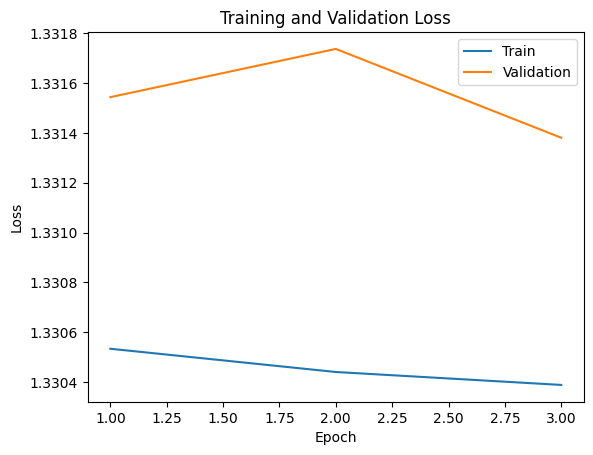

In [129]:
train_classifier(classifier, optimizer_classifier, train_latent, train_labels, val_latent, val_labels, num_epochs=3)

In [133]:
for data, labels in test_loader:
    print(labels)
    break

{'age': tensor([45, 35, 75, 38, 26, 52, 35, 52, 32, 60, 24, 26, 32, 28, 35, 15, 31, 24,
        65, 64, 35, 18, 29, 27, 75, 49, 27, 90, 18, 61, 26,  1, 36, 26, 58, 72,
        26, 58, 24, 32, 27, 34, 27, 48,  7, 22, 14, 24, 20, 30, 10, 46, 36,  7,
        29,  2, 18, 35, 39, 23,  1, 60,  3, 23]), 'gender': tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1]), 'ethnicity': tensor([3, 3, 1, 3, 0, 1, 0, 1, 1, 0, 3, 3, 2, 2, 0, 4, 3, 1, 0, 0, 0, 4, 1, 0,
        0, 0, 3, 0, 3, 0, 3, 2, 1, 0, 0, 0, 1, 0, 1, 3, 0, 0, 2, 0, 3, 3, 0, 1,
        2, 0, 0, 0, 3, 3, 0, 2, 0, 2, 1, 1, 0, 0, 2, 1])}


In [137]:
test_latent, test_labels = extract_latent(vae, test_loader)
print("Test Latent Shape:", test_latent.shape)
print("Test Labels Shape:", test_labels.shape)

Test Latent Shape: (4741, 2)
Test Labels Shape: (4741,)


# Improvements

- Increase model capacity by adding more parameters or layers to the encoder and decoder networks.
- Regularize the latent space using techniques like β-VAE or disentangled VAEs to encourage structured and disentangled representations.
- Modify the variational objective function, such as using alternative divergences like Wasserstein distance or improving the reconstruction loss term.
- Combine VAEs with generative adversarial networks (GANs) for adversarial training to generate more realistic samples.
- Condition the VAE on additional information (e.g., class labels or attributes) for more fine-grained control over generated samples.